Load the weather from CSV

In [1]:
import pandas as pd

weather_df = pd.read_csv("./data/klarchiv_01975_daily_akt/produkt_klima_tag_20190904_20210306_01975.txt", 
                             delimiter=";", skipinitialspace=True, usecols=['TMK', 'RSK', 'SHK_TAG', 'SDK',  'MESS_DATUM'],
                        parse_dates=['MESS_DATUM'])
weather_df.rename(columns={'MESS_DATUM': 'date', 'RSK': 'precipitation', 'SDK': 'sun', 'SHK_TAG': 'snow', 'TMK': 'temparature'}, inplace=True)
weather_df.set_index('date',  inplace=True)


Load the incidence data from Excel

One row is messed up, I needed to fix the date there

In [2]:
#pd.set_option('display.max_rows', 100)

incidence_df = pd.read_excel("./data/d-inzidenz-zum-download-service.xlsx", usecols=['Unnamed: 1', 'Unnamed: 2'])
incidence_df.drop([0], inplace=True)
incidence_df.rename(columns={'Unnamed: 1': 'date', 'Unnamed: 2': 'cumulative_incidence'}, inplace=True)

incidence_df.loc[[316], 'date'] = '2021-01-21 00:00:00'  # messed up date in row 316
incidence_df['date'] = pd.to_datetime(incidence_df['date'])
incidence_df.set_index('date',  inplace=True)

incidence_df['daily_incidence'] = incidence_df['cumulative_incidence'].diff()
incidence_df.drop(['cumulative_incidence'], inplace=True, axis=1)


Load the Google mobility data from CSV

In [3]:
cols = ['sub_region_1', 'date', 'retail_and_recreation_percent_change_from_baseline', 
        'grocery_and_pharmacy_percent_change_from_baseline',
        'parks_percent_change_from_baseline',
        'transit_stations_percent_change_from_baseline',
        'workplaces_percent_change_from_baseline',
        'residential_percent_change_from_baseline']

mobility_df = pd.read_csv("./data/2020_DE_Region_Mobility_Report.csv", usecols=cols, parse_dates=['date'])
mobility_df = mobility_df.loc[mobility_df['sub_region_1'] == "Hamburg"]
mobility_df.reset_index(drop=True, inplace=True)
mobility_df.set_index('date',  inplace=True)


Join all the data frames to one big data frame

In [4]:
df = weather_df.join(incidence_df).join(mobility_df)
df.dropna(subset=['sub_region_1', 'daily_incidence'], inplace=True)


I think values where this seems appropriate should be scaled to a value between 0 and 1

I'm replacing the weather and mobility stuff but keep the original incidence cause this may be interesting to look at later.

In [5]:
import sklearn.preprocessing as prep

scaler = prep.MinMaxScaler()

scale_and_replace_cols = ['precipitation', 'temparature', 'sun', 'snow',
                          'grocery_and_pharmacy_percent_change_from_baseline',
                          'parks_percent_change_from_baseline',
                          'transit_stations_percent_change_from_baseline',
                          'workplaces_percent_change_from_baseline',
                          'residential_percent_change_from_baseline']
df[scale_and_replace_cols] = scaler.fit_transform(df[scale_and_replace_cols])

df[['daily_incidence_scaled']] = scaler.fit_transform(df[['daily_incidence']])


To predict the future I think the data needs to be split somehow

<AxesSubplot:xlabel='date'>

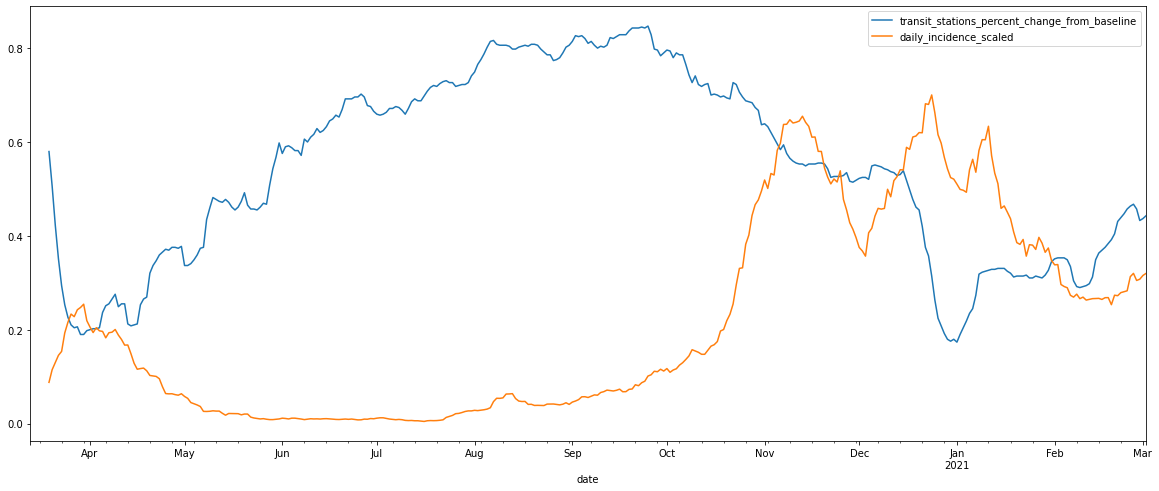

In [21]:
df[['transit_stations_percent_change_from_baseline', 'daily_incidence_scaled']].rolling(7).mean().plot(figsize=(20,8))